# **K-Means Clustering**

## Introduction to clustering

Often, the data you encounter in the real world won’t have flags attached and won’t provide labeled answers to your question. Finding patterns in this type of data, unlabeled data, is a common theme in many machine learning applications. *Unsupervised Learning* is how we find patterns and structure in these data.

Clustering is the most well-known unsupervised learning technique. It finds structure in unlabeled data by identifying similar groups, or clusters. Examples of clustering applications are:
- Recommendation engines: group products to personalize the user experience
- Search engines: group news topics and search results
- Market segmentation: group customers based on geography, demography, and behaviors
- Image segmentation: medical imaging or road scene segmentation on self-driving cars

In addition to clustering, there are several other techniques that can be used for unsupervised learning.
- **Artificial neural networks** are inspired by the neural networks in real brains, like the ones that humans or animals have. These typically comprise of a graph-like interconnection of nodes, which represent neurons, that takes in input values, perform calculations along each connection, then produces some output values at the end.
- **Latent variable models** are models that makes inferences based on some observable variables. They can include a few different algorithms and approaches, such as principal component analysis and singular value decomposition.
- **Anomaly detection** is used to find anomalies, or unexpected patterns or behaviors, in the datasets which differ greatly from the rest of the data.

In [214]:
from copy import deepcopy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from os.path import join, dirname, abspath
import pandas as pd
import requests
import random
import seaborn as sns
from sklearn import datasets
from sklearn.cluster import KMeans

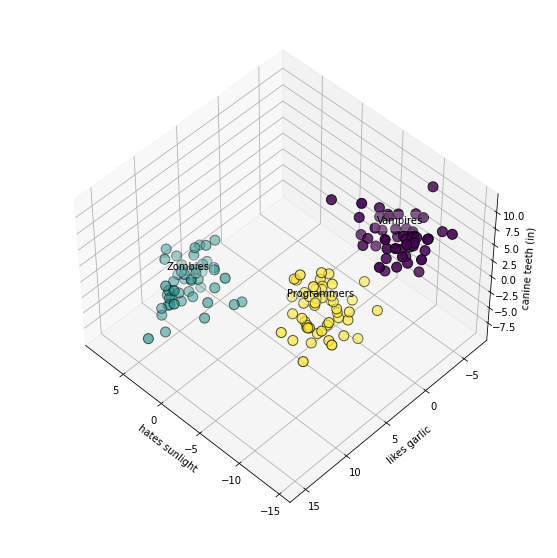

In [215]:
x, y = datasets.make_blobs(n_samples=150, centers=3, n_features=4, cluster_std=2, random_state=23)

fig = plt.figure(1, figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d', position=[0, 0, .95, 1], elev=48, azim=134, auto_add_to_figure=False)

for name, label in [('Zombies', 0), ('Programmers', 1), ('Vampires', 2)]:
    ax.text3D(x[y == label, 2].mean(),
              x[y == label, 1].mean(),
              x[y == label, 3].mean() + 2, name,
              horizontalalignment='center',
              bbox=dict(alpha=.2, edgecolor='w', facecolor='w'))

# reorder the labels to have colors matching the cluster results
y = np.choose(y.astype(int), [1, 2, 0]).astype(int)
ax.scatter(x[:, 2], x[:, 1], x[:, 3], c=y, edgecolor='k', s=100)

ax.set_xlabel('hates sunlight')
ax.set_ylabel('likes garlic')
ax.set_zlabel('canine teeth (in)')

ax.set_title('')
ax.dist = 12

fig.add_axes(ax);

## K-means clustering

The goal of clustering is to separate data so that data similar to one another are in the same group, while data different from one another are in different groups. So two questions arise:
- How many groups do we choose?
- How do we define similarity?

*K-Means* is the most popular and well-known clustering algorithm, and it tries to address these two questions.
- The “K” refers to the number of clusters (groups) we expect to find in a dataset.
- The “Means” refers to the average distance of data to each cluster center, also known as the *centroid*, which we are trying to minimize.

It is an iterative approach:
- Place `k` random centroids for the initial clusters.
- Assign data samples to the nearest centroid.
- Update centroids based on the above-assigned data samples.

Repeat Steps 2 and 3 until *convergence* (when points don’t move between clusters and centroids stabilize).

Once we are happy with our clusters, we can take a new unlabeled datapoint and quickly assign it to the appropriate cluster.

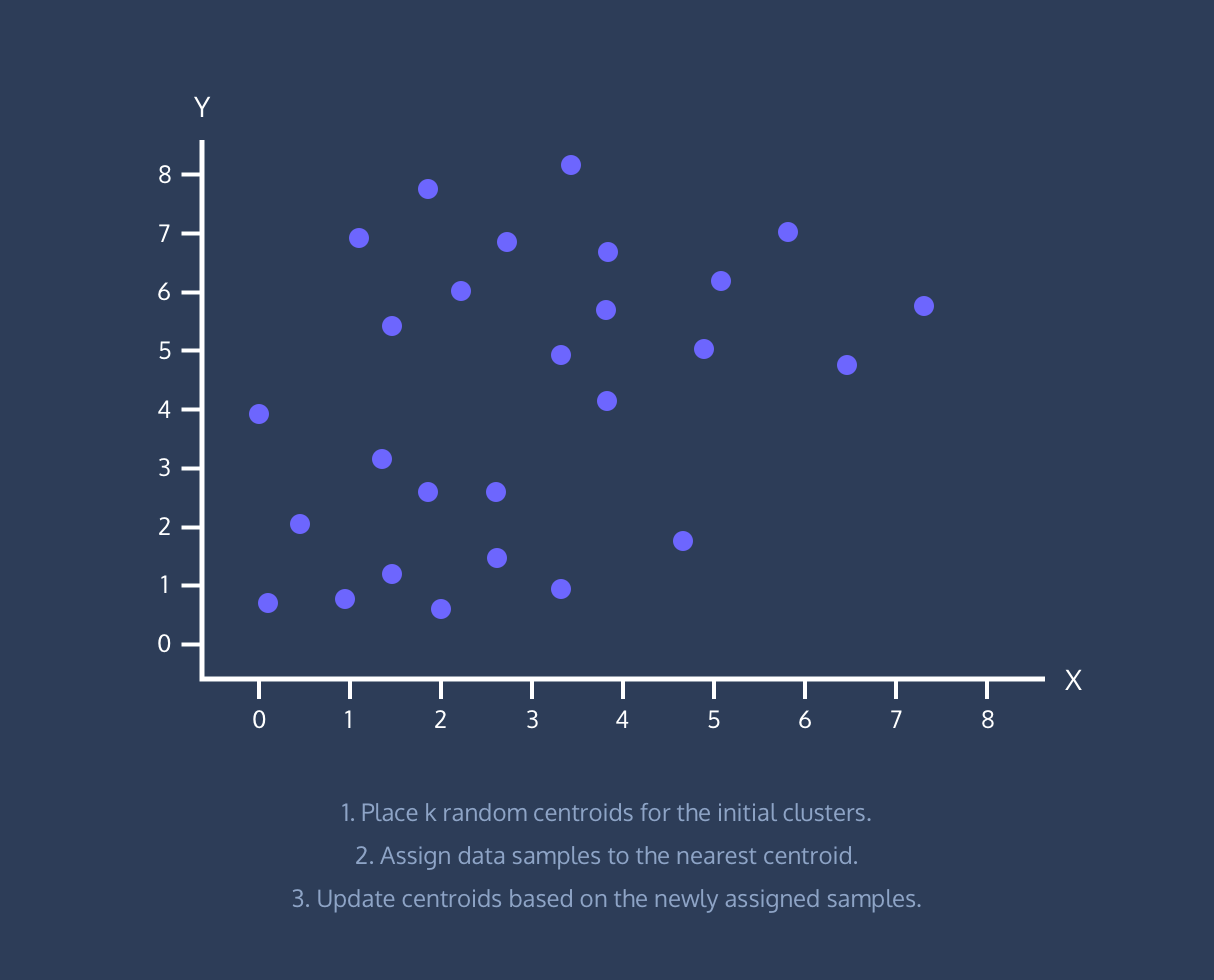 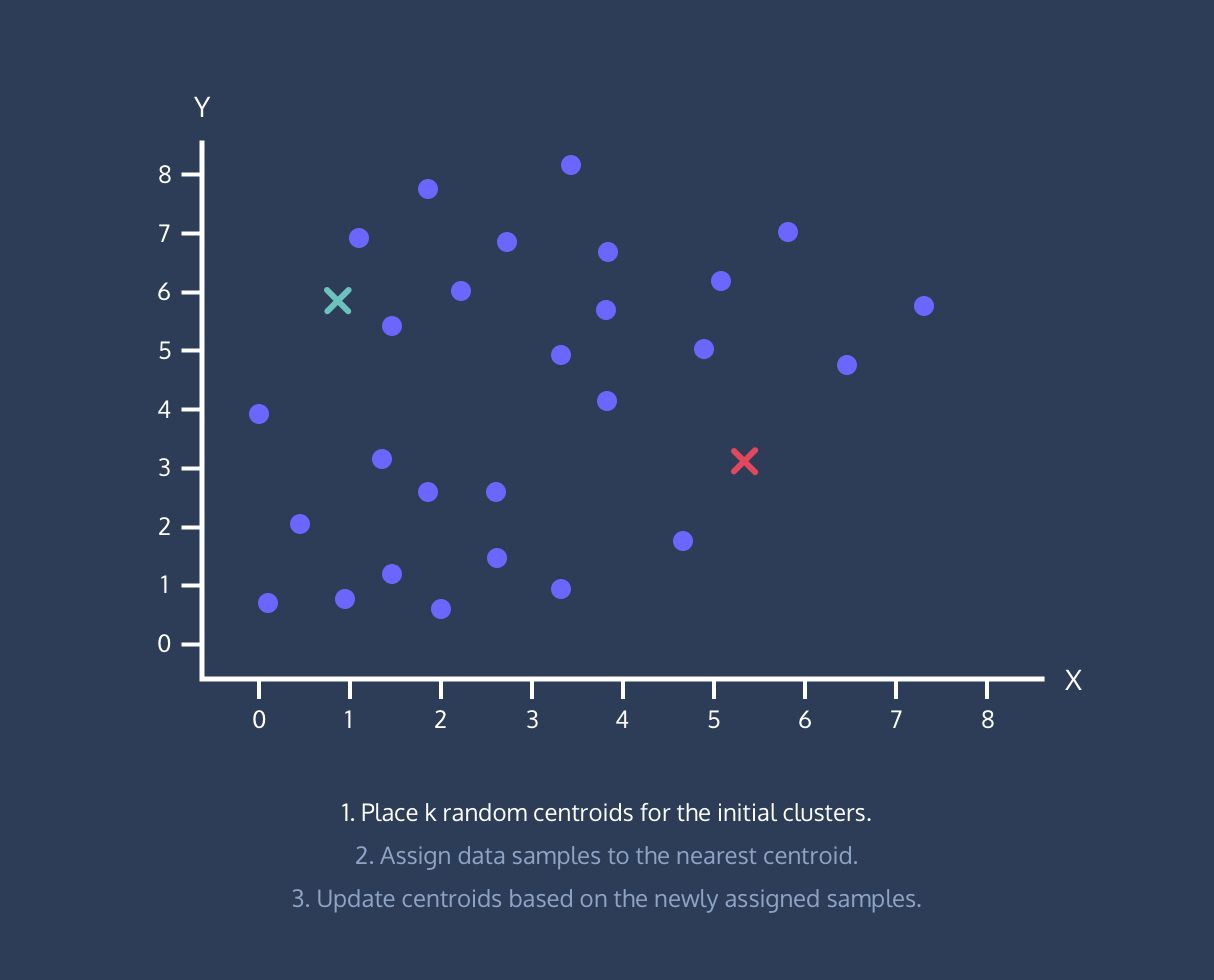 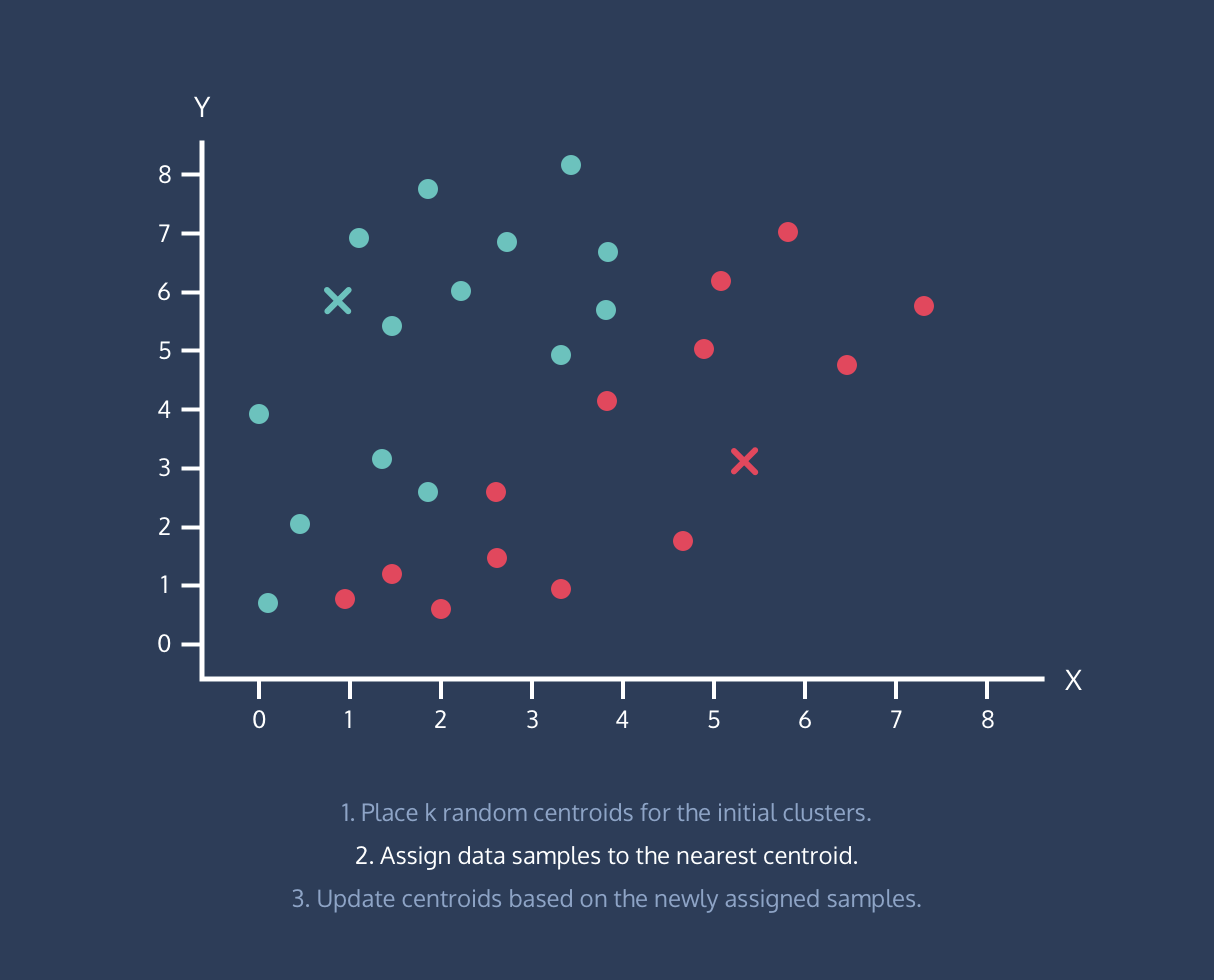 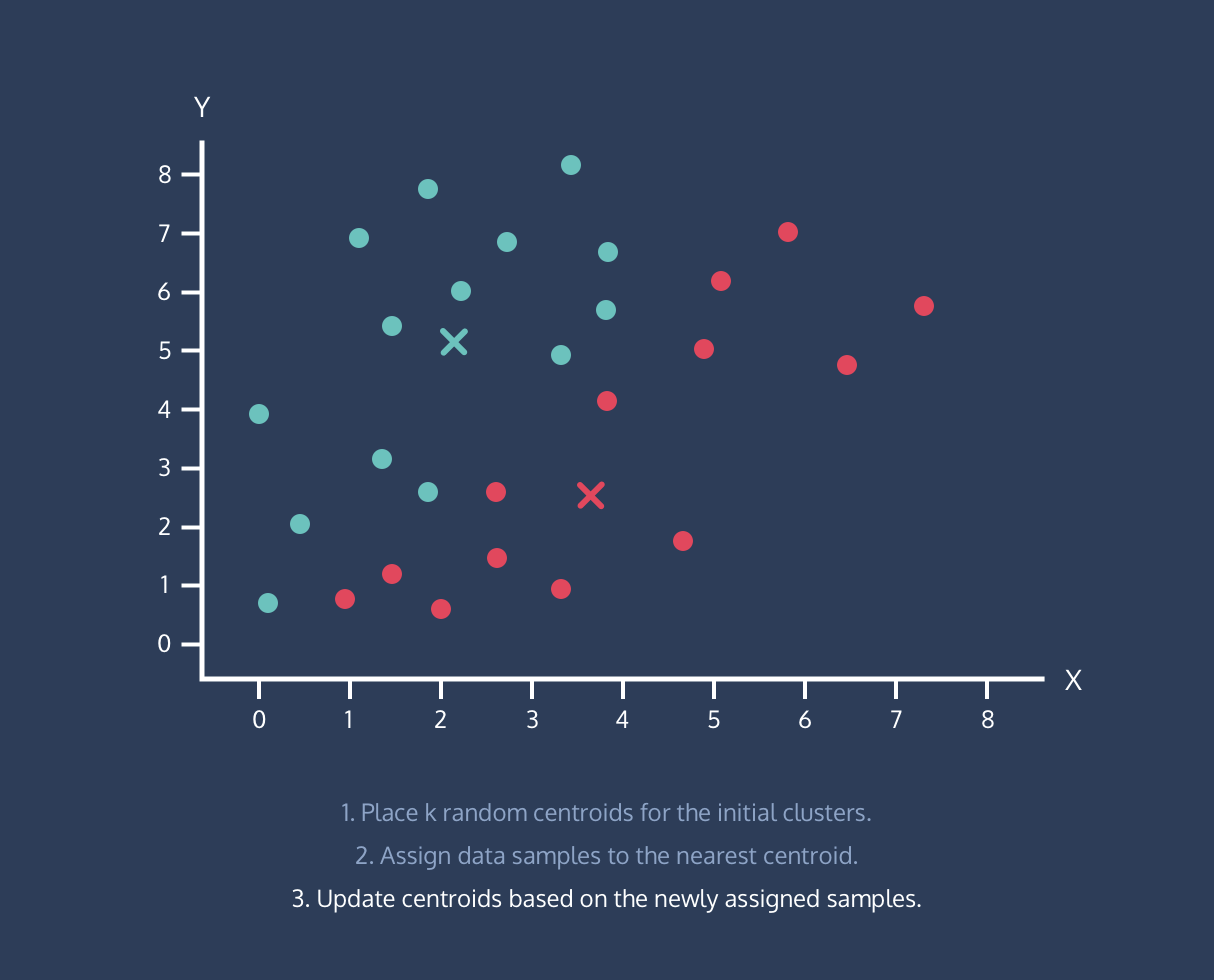
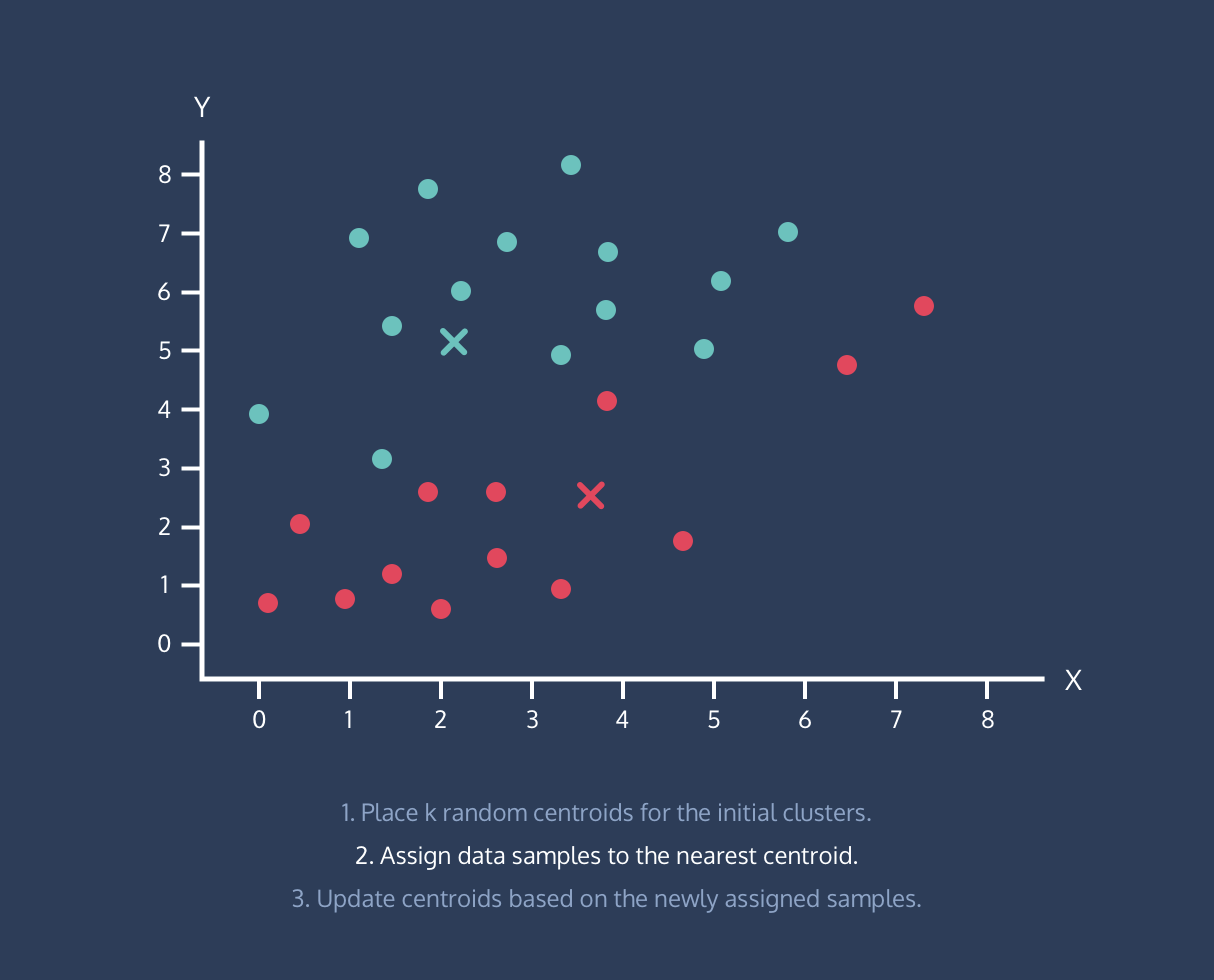 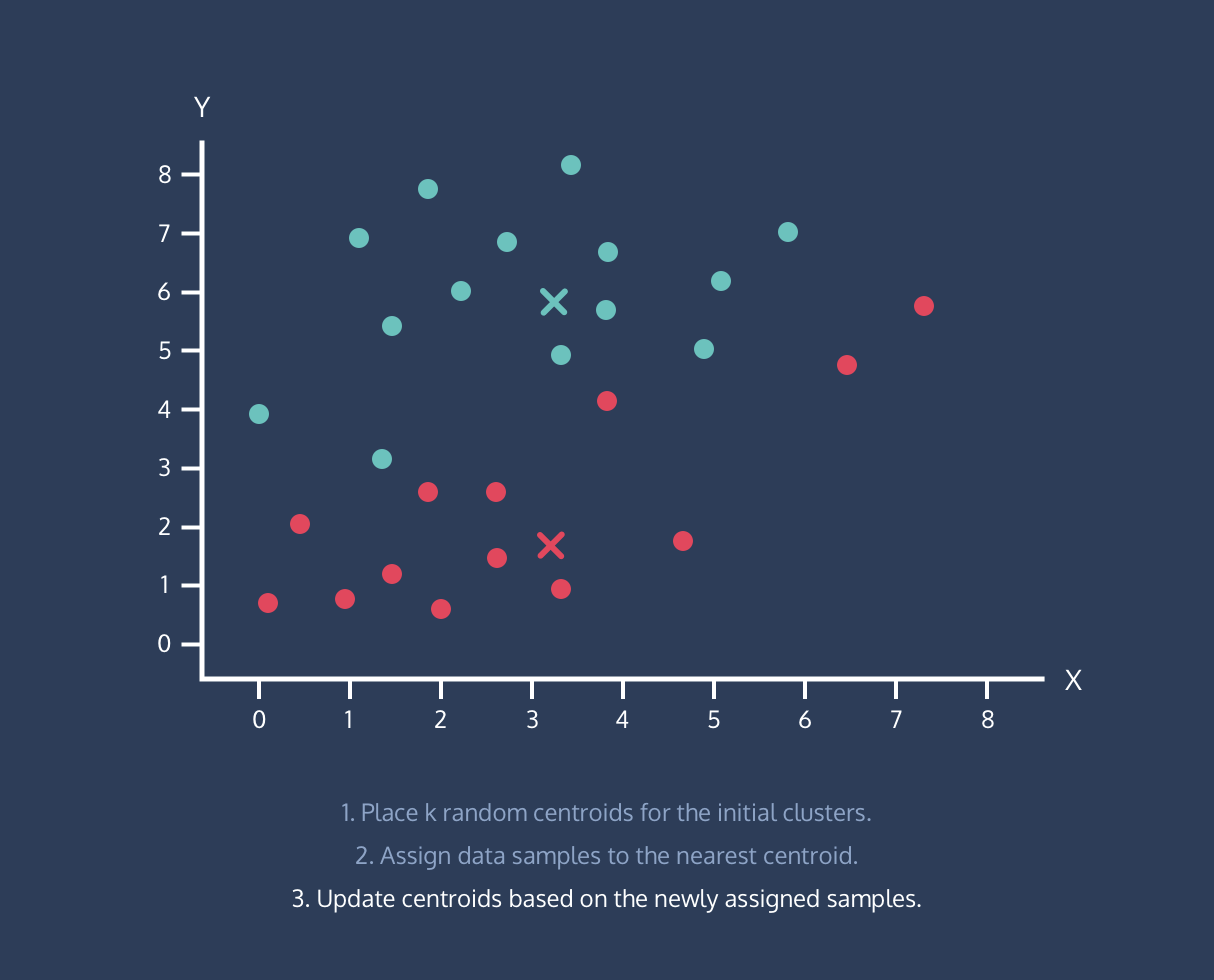
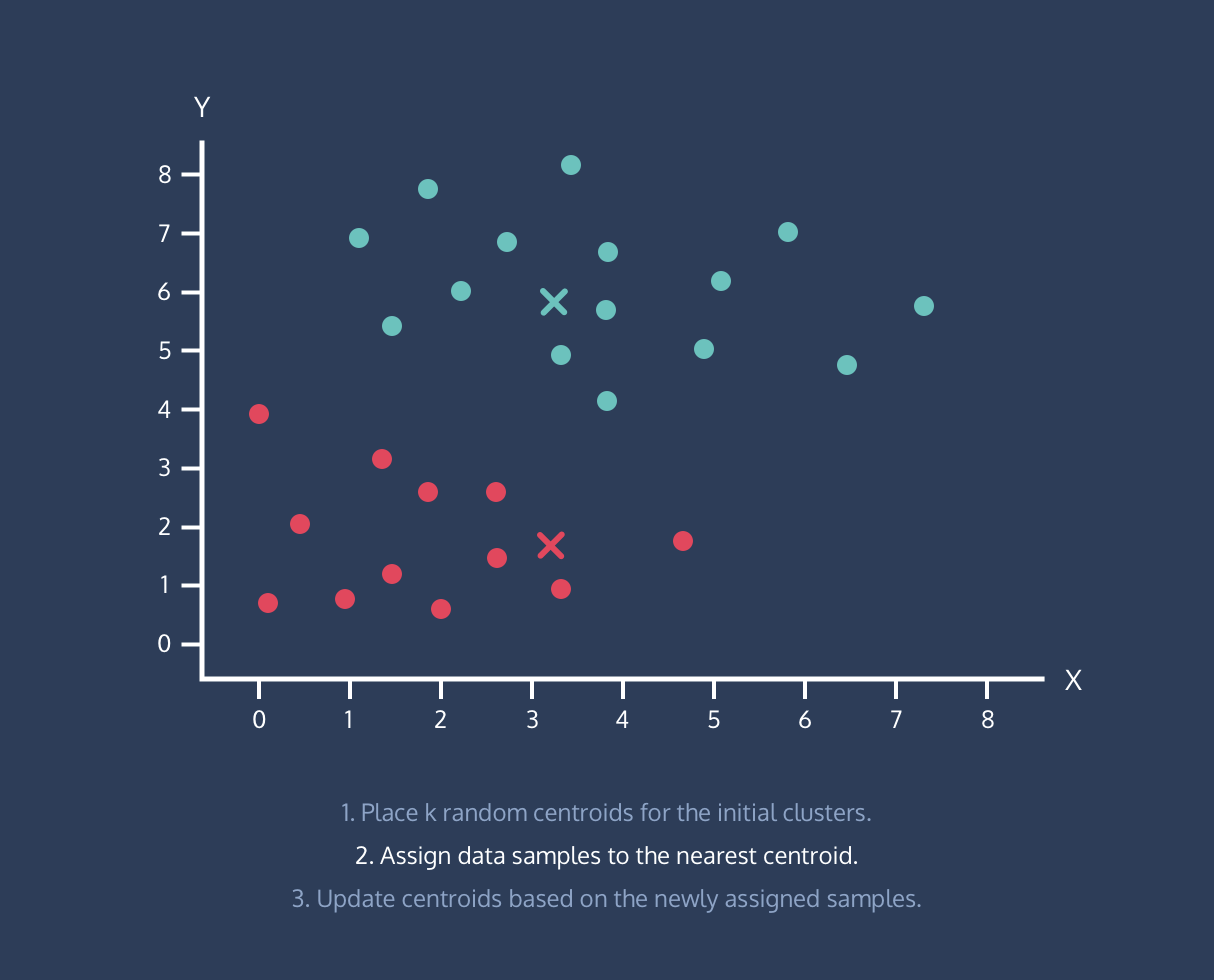 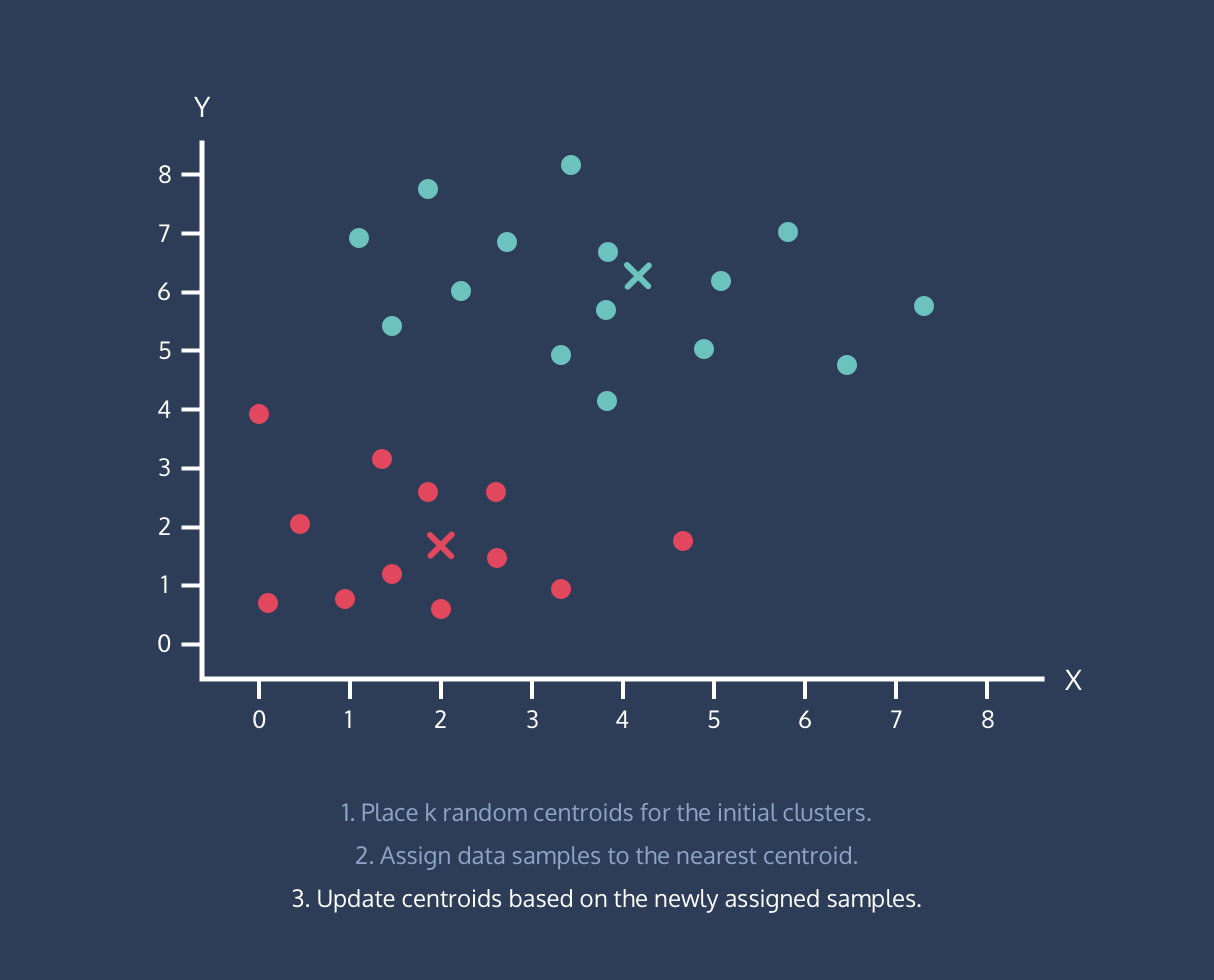

*Can the centroids be incorrect even if there is convergence? How?*

Yes, absolutely. K-Means clustering finishes once the centroids no longer update, and have converged, even if they are completely incorrect. There are several reasons as to why this can happen for K-Means clustering, which are given as follows.

One common reason is that the value chosen for k was not ideal. A value that is too low can cause centroids to include more than one cluster’s data points, and a value too large can cause clusters to be divided further among different centroids.

Furthermore, there can be incorrect assumptions made about the data. One wrong assumption is that the data is always clustered in spherical shapes, which is not always the case. The data can take on many different shapes, like a ring, or even a long rectangular shape. And, another incorrect assumption is that clusters are the same size, but, you may have some clusters that are much more dense than others or much larger in size.

Despite these possible reasons for having an incorrect result, K-Means clustering attempts to find a solution by repeating the entire process several times and then choosing the best result of those runs. However, this does not resolve all the possible issues, like a wrong choice of k.

## Wine dataset

Before we implement the K-means algorithm, let’s find a dataset. The UCI ML repository wine dataset is the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines.

The attributes are:
- Alcohol
- Malic acid
- Ash
- Alcalinity of ash
- Magnesium
- Total phenols
- Flavanoids
- Nonflavanoid phenols
- Proanthocyanins
- Color intensity
- Hue
- OD280/OD315 of diluted wines
- Proline

In [216]:
wine = datasets.load_wine()
print(wine.data)
print('-----')
print(wine.feature_names)
print('-----')
print(wine.target)
print('-----')
print(wine.target_names)
print('-----')
print(wine.DESCR)

[[1.423e+01 1.710e+00 2.430e+00 ... 1.040e+00 3.920e+00 1.065e+03]
 [1.320e+01 1.780e+00 2.140e+00 ... 1.050e+00 3.400e+00 1.050e+03]
 [1.316e+01 2.360e+00 2.670e+00 ... 1.030e+00 3.170e+00 1.185e+03]
 ...
 [1.327e+01 4.280e+00 2.260e+00 ... 5.900e-01 1.560e+00 8.350e+02]
 [1.317e+01 2.590e+00 2.370e+00 ... 6.000e-01 1.620e+00 8.400e+02]
 [1.413e+01 4.100e+00 2.740e+00 ... 6.100e-01 1.600e+00 5.600e+02]]
-----
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
-----
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
-----
['

## Visualise before k-means

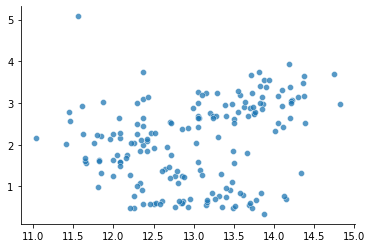

In [217]:
samples = wine.data
x = samples[:, 0]
y = samples[:, 6]

# zip x and y into a single array
wine_features = np.array(list(zip(x, y)))

sns.scatterplot(x=x, y=y, alpha=0.75)
sns.despine()

## Implementing k-means: Step 1

The K-Means algorithm:
1. **Place `k` random centroids for the initial clusters.**
2. Assign data samples to the nearest centroid.
3. Update centroids based on the above-assigned data samples.
4. Repeat Steps 2 and 3 until convergence.

After looking at the scatter plot and having a better understanding of the data, let’s start implementing the K-Means algorithm.

Because we expect there to be three clusters (for the three types of wine), let’s implement K-Means where the `k` is 3.

Using the NumPy library, we will create three *random* initial centroids and plot them along with our samples.

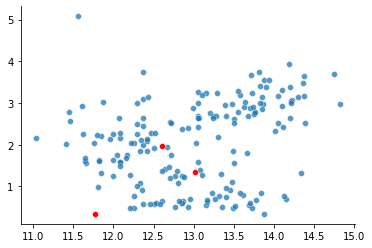

In [218]:
# number of clusters
k = len(np.unique(wine.target))

# create x and y coordinates of k random centroids
centroids_x = np.random.uniform(min(x), max(x), k)
centroids_y = np.random.uniform(min(y), max(y), k)
centroids = np.array(list(zip(centroids_x, centroids_y)))

# plot the data and centroids
fig, ax = plt.subplots()
sns.scatterplot(x=x, y=y, ax=ax, alpha=0.75)
sns.scatterplot(x=centroids_x, y=centroids_y, ax=ax, color='red')
sns.despine();

*Is it possible for more than one of these centroids to be generated at the same point?*

Yes, this is possible due to the nature of randomisation, but it is very, very unlikely. In some cases, you may even implement the algorithm so that any taken positions cannot be taken by another centroid.

In the rare chance that this does happen, it will not have too much of a consequence. The entire process of K-Means is usually run multiple times, so on different executions, the centroids will initially be placed at different locations. This is done so that it can choose the most accurate of the tests and reduce error.

## Implementing k-means: Step 2

Now we have the three random centroids. Let’s assign data points to their nearest centroids.

To do this we’re going to use a Distance Formula to write a `distance()` function. Then, we are going to iterate through our data samples and compute the distance from each data point to each of the 3 centroids.

Suppose we have a point and a list of three distances in `distances` and it looks like `[15, 20, 5]`, then we would want to assign the data point to the 3rd centroid. The `argmin(distances)` would return the index of the lowest corresponding distance, `2`, because the index `2` contains the minimum value.

In [219]:
# create a 2D distance function
def distance(a, b):
    one = (a[0] - b[0]) ** 2
    two = (a[1] - b[1]) ** 2
    distance = (one+two) ** 0.5
    
    return distance

# create an empty array to hold the resulting labels
labels = np.zeros(len(samples))
# create an empty array to hold the distance to each centroid
distances = np.zeros(k)

# assign each datapoint to the closest centroid
for i in range(len(samples)):
    for j in range(k):
        distances[j] = distance(wine_features[i], centroids[j])
    cluster = np.argmin(distances)
    labels[i] = cluster

print(labels)

[0. 0. 0. 0. 0. 0. 2. 0. 2. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 2. 2. 0. 0. 0. 0. 0. 2. 0. 2. 0.
 2. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 1. 2. 0. 0. 0.
 1. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 1. 2. 1. 1. 2. 2. 2. 2. 2. 2.
 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 1. 2. 2. 2. 2. 2. 2. 2.]


## Implementing k-means: Step 3

Find *new* cluster centers by taking the average of the assigned points.

In [220]:
# create a copy of the centroids
centroids_old = deepcopy(centroids)

for i in range(k):
    # extract all the points that belong to cluster i
    points = [wine_features[j] for j in range(len(wine_features)) if labels[j] == i]
    # calculate their average value
    centroids[i] = np.mean(points, axis=0)

print("Old:", centroids_old)
print("Updated:", centroids)

Old: [[12.61143175  1.96361273]
 [11.77303391  0.34808277]
 [13.02047214  1.34773486]]
Updated: [[12.93285714  2.63571429]
 [12.25363636  0.74636364]
 [13.288       1.05090909]]


## Implementing k-means: Step 4

This is the part of the algorithm where we repeatedly execute Step 2 and 3 until the centroids stabilise (convergence).

We can do this using a `while` loop. And everything from Step 2 and 3 goes inside the loop.

For the condition of the `while` loop, we need to create an array named errors. In each error index, we calculate the difference between the updated centroid (centroids) and the old centroid (centroids_old).

The loop ends when all three values in errors are 0.

In [221]:
# start with randomly-located centroids
centroids = np.array(list(zip(centroids_x, centroids_y)))

# store the value of centroids when it updates
centroids_old = np.zeros(centroids.shape)

# empty lists to hold the cluster labels and centroid distances
labels = np.zeros(len(samples))
distances = np.zeros(k)

# initialise the error
error = np.zeros(k)

for i in range(k):
    error[i] = distance(centroids[i], centroids_old[i])
print('Initial error:', error)

# repeat until convergence:
while error.all() != 0:

    # assign samples to the nearest centroid
    for i in range(len(samples)):
        for j in range(k):
            distances[j] = distance(wine_features[i], centroids[j])
        cluster = np.argmin(distances)
        labels[i] = cluster
    
    # update the centroids
    centroids_old = deepcopy(centroids)
    
    for i in range(k):
        points = [wine_features[j] for j in range(len(wine_features)) if labels[j] == i]
        centroids[i] = np.mean(points, axis=0)

    for i in range(k):
        error[i] = distance(centroids[i], centroids_old[i])
    print('Updated error:', error)

Initial error: [12.76338458 11.77817851 13.09003758]
Updated error: [0.74500657 0.62418456 0.39959566]
Updated error: [0.25726357 0.4239851  0.10607286]
Updated error: [0.28045845 0.37846481 0.08554898]
Updated error: [0.1602906  0.22365462 0.0944476 ]
Updated error: [0.06856805 0.15741092 0.08737087]
Updated error: [0.06197718 0.10570189 0.04820749]
Updated error: [0.03192373 0.07722966 0.05036446]
Updated error: [0. 0. 0.]


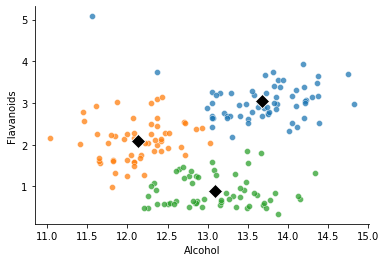

In [222]:
fig, ax = plt.subplots()
for i in range(k):
    points = np.array([wine_features[j] for j in range(len(samples)) if labels[j] == i])
    sns.scatterplot(x=points[:, 0], y=points[:, 1], alpha=0.75, ax=ax)

sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], s=100, marker="D", ax=ax, color="black")

plt.xlabel('Alcohol')
plt.ylabel('Flavanoids')
sns.despine();

## Implementing k-means: Scikit-learn

Awesome, you have implemented K-Means clustering from scratch!

Writing an algorithm whenever you need it can be very time-consuming and you might make mistakes and typos along the way. We will now show you how to implement K-Means more efficiently – using the scikit-learn library.

Instead of implementing K-Means from scratch, the `sklearn.cluster` module has many methods that can do this for you.

To import KMeans from `sklearn.cluster`:

`from sklearn.cluster import KMeans`

For Step 1, use the `KMeans()` method to build a model that finds `k` clusters. To specify the number of clusters (`k`), use the `n_clusters` keyword argument:

`model = KMeans(n_clusters = k)`

For Steps 2 and 3, use the `.fit()` method to compute K-Means clustering:

`model.fit(X)`

After K-Means, we can now predict the closest cluster each sample in X belongs to. Use the `.predict()` method to compute cluster centers and predict cluster index for each sample:

`model.predict(X)`

In [223]:
model = KMeans(n_clusters=3)
model.fit(samples)
labels = model.predict(samples)
print(labels)

[1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 1 1 0 1 1 1 1 1 1 0 0
 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 2 0 2 2 0 2 2 0 0 0 2 2 1
 0 2 2 2 0 2 2 0 0 2 2 2 2 2 0 0 2 2 2 2 2 0 0 2 0 2 0 2 2 2 0 2 2 2 2 0 2
 2 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 0 2 2 0 0 0 0 2 2 2 0 0 2 2 0 0 2 0
 0 2 2 2 2 0 0 0 2 0 0 0 2 0 2 0 0 2 0 0 0 0 2 2 0 0 0 0 0 2]


## New Data?

Since you have created a model that computed K-Means clustering, you can now feed new data samples into it and obtain the cluster labels using the `.predict()` method.

So, suppose we went to Italy and obtained the chemical analysis of five more wines.

We can feed this new data into the model and obtain the labels for them.

In [224]:
# generate the data for the new wines
num_new_wines = 5
wine_df = datasets.load_wine(as_frame=True)['data']
results = [random.choices(wine_df[col], k = num_new_wines) for col in wine_df.columns]

new_wines = []
for i in range(len(results[0])):
    temp_list = [lst[i] for lst in results]
    new_wines.append(temp_list)

print(new_wines)
# convert into a NumPy array
new_wines_arr = np.array(new_wines)

# make predictions
labels = model.predict(new_wines_arr)
print(labels)

[[12.85, 2.45, 2.92, 16.0, 98.0, 2.45, 0.55, 0.32, 1.92, 2.65, 0.96, 2.52, 735.0], [11.46, 0.74, 2.1, 19.0, 96.0, 3.3, 0.6, 0.24, 1.35, 7.1, 0.86, 2.73, 937.0], [13.05, 1.9, 2.25, 25.0, 126.0, 2.2, 3.18, 0.17, 0.96, 6.8, 0.99, 1.75, 1050.0], [14.83, 0.92, 2.12, 20.4, 98.0, 1.25, 0.49, 0.24, 0.84, 2.6, 1.15, 3.33, 1095.0], [13.08, 1.35, 2.28, 17.2, 96.0, 2.1, 2.78, 0.28, 1.56, 5.7, 0.95, 1.62, 680.0]]
[0 0 1 1 0]


## Visualize after K-Means

We have done the following using sklearn library:
- Load the embedded dataset
- Compute K-Means on the dataset (where `k` is 3)
- Predict the labels of the data samples

And the labels resulted in either `0`, `1`, or `2`.

Let’s finish it by making a scatter plot of the data again!

This time, however, use the labels numbers as the colors.

To edit colors of the scatter plot, we can set `c = labels`:
```
plt.scatter(x, y, c=labels, alpha=0.5)
 
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
```

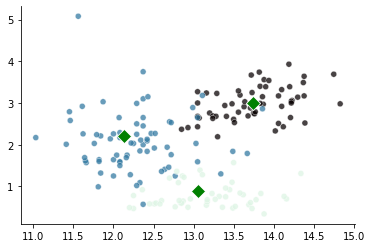

In [213]:
x = samples[:, 0]
y = samples[:, 6]

fig, ax = plt.subplots()
sns.scatterplot(x=x, y=y, hue=wine.target, alpha=0.75, legend=False, palette="mako")
sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], s=100, marker="D", ax=ax, color="green")

sns.despine()

In [225]:
len(wine.target)

178

## Evaluation

At this point, we have clustered the wine data into 3 different groups (implemented using Python and using scikit-learn). But do the clusters correspond to the actual species? Let’s find out!

First, remember that the wine dataset comes with target values:

`target = wine.target`

It looks like:

`[ 0 0 0 0 0 ... 2 2 2]`

According to the metadata:
- All the 0's are type 0
- All the 1's are type 1
- All the 2's are type 2

Let’s change these values into the corresponding types using the following code:
```
type = np.chararray(target.shape, itemsize=178)
 
for i in range(len(samples)):
  if target[i] == 0:
    type[i] = 'type 0'
  elif target[i] == 1:
    type[i] = 'type 1'
  elif target[i] == 2: 
    type[i] = 'type 2'
```
Then we are going to use the Pandas library to perform a *cross-tabulation*.

Cross-tabulations enable you to examine relationships within the data that might not be readily apparent when analyzing total survey responses.

The result should look something like:
```
labels    type 0    type 1    type 2
0             50         0         0
1              0         2        36
2              0        48        14
```

The first column has the cluster labels. The second to fourth columns have the wiune types that are clustered into each of the labels.

In [234]:
labels = model.predict(samples)
target = wine.target

types = np.chararray(target.shape, itemsize=178)
for i in range(len(samples)):
    if target[i] == 0:
        types[i] = 'type 0'
    elif target[i] == 1:
        types[i] = 'type 1'
    elif target[i] == 2: 
        types[i] = 'type 2'
        
df = pd.DataFrame({'labels': labels, 'types': types})
print(df)

ct = pd.crosstab(df['labels'], df['types'])
print(ct)

     labels      types
0         1  b'type 0'
1         1  b'type 0'
2         1  b'type 0'
3         1  b'type 0'
4         0  b'type 0'
..      ...        ...
173       0  b'type 2'
174       0  b'type 2'
175       0  b'type 2'
176       0  b'type 2'
177       2  b'type 2'

[178 rows x 2 columns]
types   b'type 0'  b'type 1'  b'type 2'
labels                                 
0              13         20         29
1              46          1          0
2               0         50         19


We can conclude that none of the clusters were identified with 100% accuracy. Each had a mix of two different types of wine at a ratio of approximately 2/3 to 1/3.

## The number of clusters

At this point, we have grouped the wines into 3 clusters. But suppose we didn’t know there are three types of wine in the dataset, what is the best number of clusters? And how do we determine that?

Before we answer that, we need to define what is a good cluster?

Good clustering results in tight clusters, meaning that the samples in each cluster are bunched together. How spread out the clusters are is measured by inertia. *Inertia* is the distance from each sample to the centroid of its cluster. The lower the inertia is, the better our model has done.

You can check the inertia of a model by:

`print(model.inertia_)`

For the wine dataset, if we graph all the `k`s (number of clusters) with their inertias:

E:\Applications\Anaconda3\envs\codecademy\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


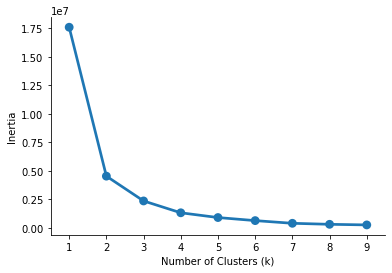

In [239]:
samples = wine.data

num_clusters = list(range(1, 10))
inertias = list()

for k in num_clusters:
    model = KMeans(n_clusters=k)
    model.fit(samples)
    inertias.append(model.inertia_)

fig, ax = plt.subplots()
sns.pointplot(x=num_clusters, y=inertias)
    
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

sns.despine()

Notice how the graph keeps decreasing.

Ultimately, this will always be a trade-off. The goal is to have low inertia and the least number of clusters.

One of the ways to interpret this graph is to use the elbow method: choose an “elbow” in the inertia plot - when inertia begins to decrease more slowly.

In the graph above, 2 or 3 is the optimal number of clusters.